In [1]:
import glob

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

The objective of this practical work is to implement the simple camera calibration method we saw in class. To do that, you will need a several pictures of a calibration pattern, which is chosen here to be a chessboard. 

In the last part, you will furthermore compare you results with the ones of openCV calibration function.

# Part I: load data

First, you have to load several calibration images, which is done in the following cell. The images are provided with this notebook.

**Question:** how many images do you need to calibrate the camera?

**Answer:**

To conduct calibration effectively, we need to estimate six parameters in total: five intrinsic parameters within the matrix $K$ along with the scale factor $s_c$. Each homography imposes two constraints, necessitating the acquisition of multiple homographies. Thus, to accurately estimate these parameters, we require a minimum of $3$ images.

**Fill** the gaps in the following cell to enter the world coordinates of the corners in the chessboard.

**Explain** why do you have to remove one of the world frame coordinate?

**Answer:**

Removing one of the world frame coordinates, typically the $Z$ coordinate, is essential in camera calibration to resolve the inherent scale ambiguity. This practice ensures that the estimated camera parameters are consistent and well-defined by setting a reference scale for the world coordinate system.

In [2]:
# First, you have to set the world coordinates of the corners in the chessboard, which we will call objpoints.
# We will consider that the cells of the chessboard have a length side of 1.
# Please note that you only have to take the inner corner of the chessbord, which correspond to full squares.
# Therefore, we will consider that there 7 row corners and 6 column corners.

objp = np.zeros((6 * 7, 3), np.float32)
# 3D coordinates in real world space. A np.array, each column corresponding to the 3D Euclidiean coordinates - the last coordinate is always chosen to be 0)
objp[:, :2] = np.mgrid[0:7, 0:6].T.reshape(-1, 2)
# Remove a useless dimension in the world coordinates. Explain.
objpoints = objp[:, :2]

Now, **fill** the code below by entering the path of the folder in which you saved the image.

**Question:** What is the code below doing?

**Answer**:

The code segment below utilizes OpenCV to detect chessboard corners in a series of images. It begins by defining termination criteria for corner detection refinement. It then iterates through each image in a specified directory, reading and converting them to grayscale. Using OpenCV's `findChessboardCorners()` function, it attempts to locate the corners of a predefined chessboard pattern within the grayscale image. Upon successful detection, it refines the corner positions with `cornerSubPix()`, appends the refined corner coordinates to a list, and visualizes the detected corners overlaid on the original image. This process enables the extraction of precise image points for subsequent use in tasks such as camera calibration.

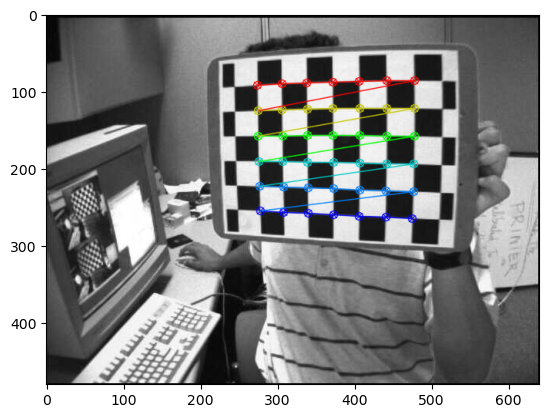

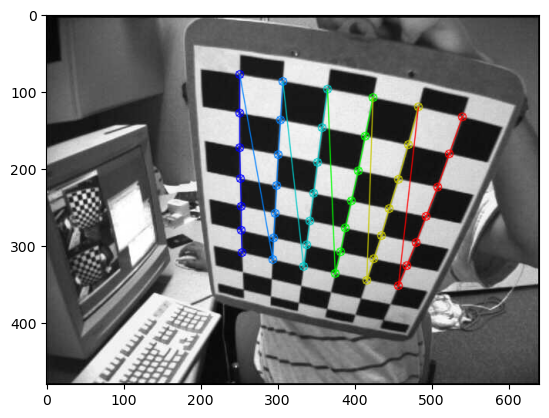

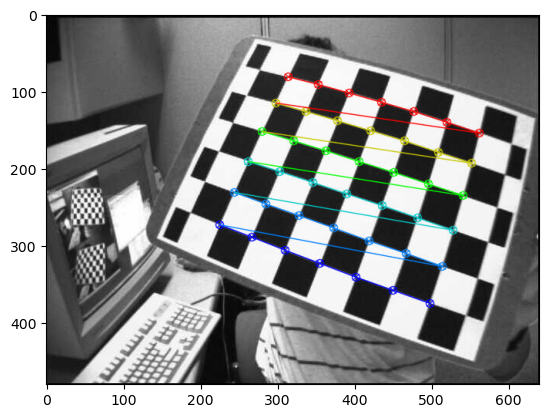

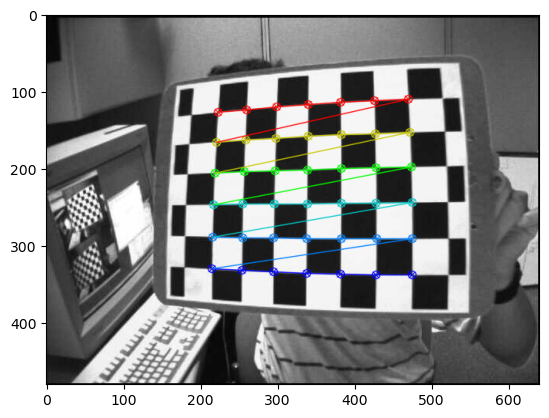

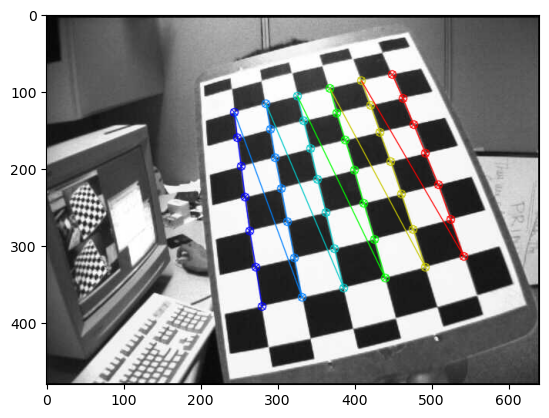

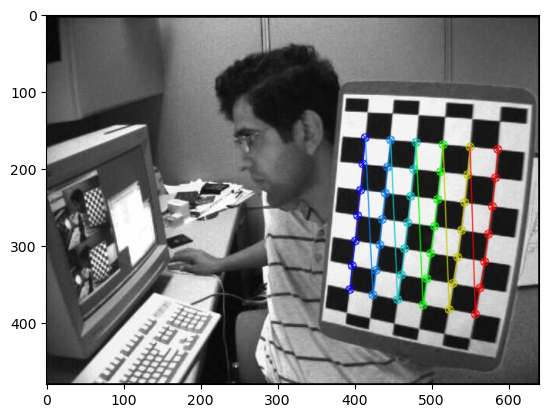

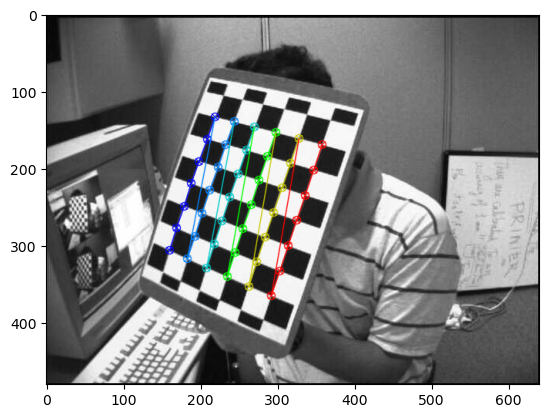

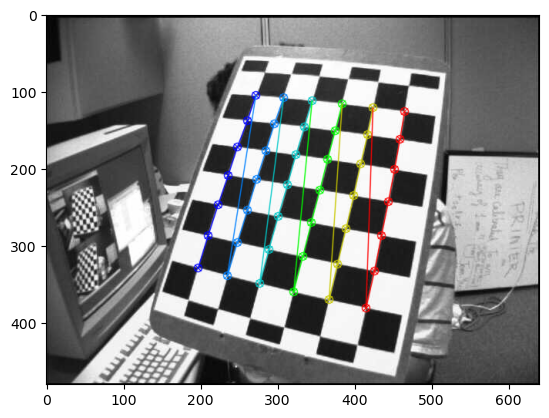

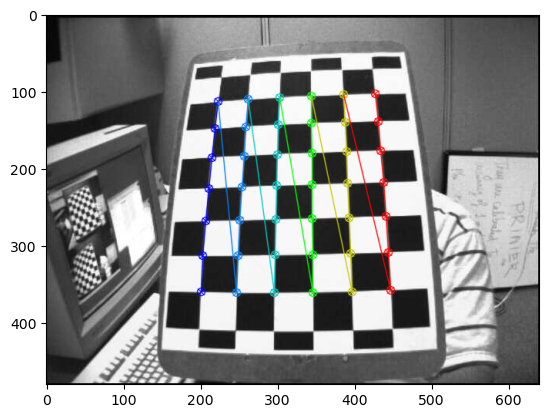

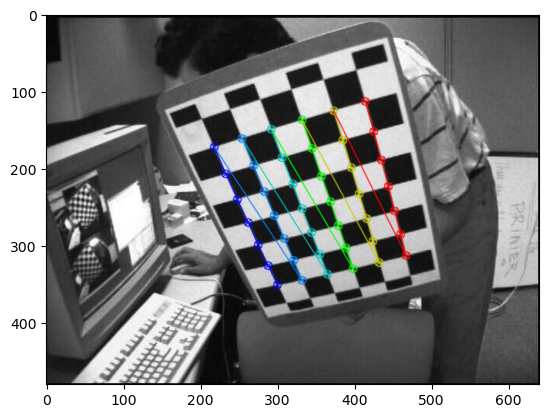

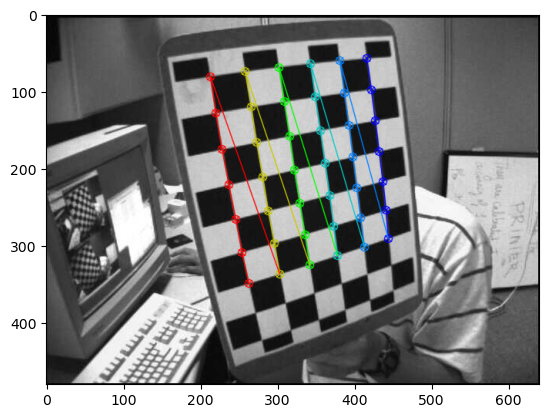

In [3]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# 2D points in image plane. List (length = nb of images) of np.array, each of size = 2
# (corresponding to the 2D Euclidiean coordinates - the coordinates might not be integers)
imgpoints = []
images = glob.glob("Chessboards/*.jpg")
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7, 6), None)
    # If found, add object points, image points (after refining them)
    if ret:
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(np.squeeze(corners2))

        # Draw and display the corners
        cv.drawChessboardCorners(img, (7, 6), corners2, ret)
        plt.imshow(img)
        plt.show()

# Part II: camera calibration

The objective of this part is to perform the camera calibration using the algorithm we saw in class.

**Question:** Recall what camera calibration is. What parameters are we looking for?

**Answer:**

Camera calibration is a process crucial for determining the intrinsic and extrinsic parameters governing the image formation process of a camera. By determining these parameters, enables accurate mapping of objects in three-dimensional space to the two-dimensional images captured by the camera.

We look for the following parameters:

- Intrinsic parameters: These parameters are specific to the camera and do not change with the camera's position or orientation in the scene. They include: 
    - Focal Lengths ($f_x$, $f_y$): Represent the scale factors between the camera's coordinate system and the pixel coordinate system in the x (horizontal) and y (vertical) directions, respectively.
    - Principal Point ($p_x$, $p_y$): The offset of the image center from the bottom-left corner of the image frame.
    - Skew Coefficient ($s$): Accounts for the non-perpendicularity between the x and y axes on the image plane.
- Extrinsic parameters: These parameters define the camera's position and orientation in the world, allowing the mapping of 3D points in the scene to 2D points in the image. They include:
  - Rotation Matrix ($R$): A $3\times3$ matrix representing the camera's orientation with respect to the world frame.
  - Camera center ($\tilde{C}$): A $3\times4$ matrix representing the inhomogeneous coordinates of the camera center in the world frame.

**Question:** Recall the main principles of the calibration algorithm we saw in class. What are the main steps that need to be implemented?

**Answer:**

Due to the projection, and choosing $Z=0$, we have:  

$$
\frac{1}{s_c}
\begin{bmatrix}
x\\
y\\
1
\end{bmatrix}
=
K[\mathbf{r_1}, \mathbf{r_2}, \mathbf{t}]
\begin{bmatrix}
X\\
Y\\
1
\end{bmatrix}
$$

We then look for the homography given by $H=[\mathbf{h_1}, \mathbf{h_2}, \mathbf{h_3}]=s_cK[\mathbf{r_1}, \mathbf{r_2}, \mathbf{t}]$, which can be estimated with the RANSAC algorithm. We know that $\mathbf{r_1}$ and $\mathbf{r_2}$ are columns of a rotation matrix (i.e. they are orthonormal). Effectively, we have:

$$
\begin{cases}
\mathbf{h_1}K^{-T}K^{-1} \mathbf{h_2} = 0\\
\mathbf{h_1}K^{-T}K^{-1} \mathbf{h_1} = \mathbf{h_2}K^{-T}K \mathbf{h_2}
\end{cases}
$$

Assuming we have at least $n\geq 3$ images of the calibration scene, we can denote: 

$$
K^{-T}K^{-1} = B =
\begin{bmatrix}
B_{11} & B_{12} & B_{13} \\
B_{21} & B_{22} & B_{23} \\
B_{31} & B_{32} & B_{33}
\end{bmatrix}
$$

or equivalently, as $B$ is symmetric:

$$
\mathbf{b} = 
\begin{bmatrix}
B_{11} \\
B_{12} \\
B_{13} \\
B_{22} \\
B_{22} \\
B_{33}
\end{bmatrix}
$$

Denoting: 

$$
\mathbf{v}_{ij} = 
\begin{bmatrix}
h_{i1}h_{j1} \\
h_{i1}h_{j2} + h_{i2}h_{j1} \\
h_{i2}h_{j2} \\
h_{i3}h_{j1} + h_{i1}h_{j3} \\
h_{i3}h_{j2} + h_{i2}h_{j3} \\
h_{i3}h_{j3} \\
\end{bmatrix}
$$

for a given homography we have:

$$
\begin{bmatrix}
v_{12}^T \\
(v_{11} - v_{22})^T
\end{bmatrix}
\mathbf{b}
=
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

Stacking all the constraints together for multiple homographies, we obtain:

$$
V\mathbb{b}=\mathbb{0}
$$

with $V$ a $2n\times 6$ matrix. Due to noise there is not an exact solution, so we resort to a least square estimation of $b$, which in turn allows to recover $K$ using a Cholesky decomposition. Then, the five intrinsic parameters within the matrix $K$ are finally obtained which can be used to derive the extrinsic parameters of the calibration.

To compute the calibration matrix, we first be able to compute some homographies between images. As you have already done so in the previous practical work, some code is provided below.

**Question:** What is the name of the homography estimation algorithm implemented below?

**Answer:** 

The homography estimation algorithm implemented below is the Direct Linear Transform (DLT) algorithm.

In [4]:
# Homography computation. See the previous pratical work for more details.
def svd_solve(A):
    """Solve a homogeneous least squares problem with the SVD
       method.

    Args:
       A: Matrix of constraints.
    Returns:
       The solution to the system.
    """
    U, S, V_t = np.linalg.svd(A)
    idx = np.argmin(S)

    least_squares_solution = V_t[idx]

    return least_squares_solution


def to_homogeneous(A):
    """Convert a stack of inhomogeneous vectors to a homogeneous
    representation.
    """
    A = np.atleast_2d(A)

    N = A.shape[0]
    A_hom = np.hstack((A, np.ones((N, 1))))

    return A_hom


def calculate_normalization_matrix(data):
    """Calculates zero-centered, sqrt(2) distance transformed
    matrix transform for data.

    Args:
       data: Nx2 stack of data points
     Returns:
       The normalization matrix
    """
    if data.ndim != 2 or data.shape[-1] != 2:
        raise ValueError("Dataset must be a collection of 2D points")

    x, y = data[:, 0], data[:, 1]

    N = data.shape[0]

    x_mean, y_mean = x.mean(), y.mean()
    x_var, y_var = x.var(), y.var()

    # Form rescaling matrix so that data points will lie
    # sqrt(2) from the origin on average.
    s_x, s_y = np.sqrt(2.0 / x_var), np.sqrt(2.0 / y_var)

    norm_matrix = np.array(
        [[s_x, 0.0, -s_x * x_mean], [0.0, s_y, -s_y * y_mean], [0.0, 0.0, 1.0]]
    )

    return norm_matrix


def calculate_homography(model, data):
    """Perform linear least squares to calculate homography between planar
    model and sensor data
    """
    N = model.shape[0]

    # Normalize data
    norm_matrix_model = calculate_normalization_matrix(model)
    norm_matrix_data = calculate_normalization_matrix(data)

    model = to_homogeneous(model)
    data = to_homogeneous(data)

    model_norm = np.dot(model, norm_matrix_model.T)
    data_norm = np.dot(data, norm_matrix_data.T)

    X, Y, x, y = model_norm[:, 0], model_norm[:, 1], data_norm[:, 0], data_norm[:, 1]

    # Mount homogeneous constraint matrix (See Burger pg. 11-13 for a derivation)
    A = np.zeros((N * 2, 9))

    x_component = np.zeros((N, 9))
    x_component[:, 0] = -X
    x_component[:, 1] = -Y
    x_component[:, 2] = -1.0
    x_component[:, 6] = x * X
    x_component[:, 7] = x * Y
    x_component[:, 8] = x

    y_component = np.zeros((N, 9))
    y_component[:, 3] = -X
    y_component[:, 4] = -Y
    y_component[:, 5] = -1.0
    y_component[:, 6] = y * X
    y_component[:, 7] = y * Y
    y_component[:, 8] = y

    # Note that all x-constraints precede all y-constraints for convenience of
    # representation.
    A[:N] = x_component
    A[N:] = y_component

    # Solve homogeneous system
    h_norm = svd_solve(A)

    # Reconstitute normalized homography
    H_norm = h_norm.reshape((3, 3))

    # Denormalize
    H = np.dot(np.dot(np.linalg.inv(norm_matrix_data), H_norm), norm_matrix_model)

    return H

In the following cell, compute the homographies for all the calibrations images in which you have extracted the corner coordinates. 

**Question:** what is the format of the homographies variable? Explain.

**Answer:**

In the following code snippet, we estimate a homography for each `.jpg` image in the `Chessboards` directory, provided that chessboard corners are successfully detected. Consequently, `homographies` is a list of $3 \times 3$ matrices, each represented as a `np.array`, which encapsulates transformations mapping the plane defined by the recognized corners to the plane specified by `objpoints`.

In [5]:
# Finds the homography for each image
homographies = []
for iData in range(len(imgpoints)):
    H = calculate_homography(objpoints, imgpoints[iData])
    homographies.append(H)

In [6]:
homographies[0]

array([[-1.62526799e+01, -1.19965499e+00,  2.66767925e+02],
       [ 1.27784373e+00, -2.03529837e+01,  1.48192972e+02],
       [ 8.40383597e-03, -2.96680023e-03,  5.59795925e-01]])

Now, let us start doing the calibration itself. To do that, as seen during the class, you will have to solve a linear system $\mathbf{Vb = 0}$. Recall how the $\mathbf{V}$ matrix is computed from the different homographies found previously.

**Answer:**

As already seen in a previous question, for a given homography we have:

$$
\mathbf{v}_{ij} = 
\begin{bmatrix}
h_{i1}h_{j1} \\
h_{i1}h_{j2} + h_{i2}h_{j1} \\
h_{i2}h_{j2} \\
h_{i3}h_{j1} + h_{i1}h_{j3} \\
h_{i3}h_{j2} + h_{i2}h_{j3} \\
h_{i3}h_{j3} \\
\end{bmatrix}
$$

which yields:

$$
\begin{bmatrix}
v_{12}^T \\
(v_{11} - v_{22})^T
\end{bmatrix}
\mathbf{b}
=
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

Stacking all the constraints together for multiple homographies, we obtain:

$$
V\mathbb{b}=\mathbb{0}
$$

with $V$ a $2n\times 6$ matrix, and $n$ the number of estimated homographies used for the calibration.

There are two constraints used for performing calibration: the orthogonality constraint and the normalization constraint. Both can be implemented using the $\mathbf{v}_{ij}$ matrix: $\mathbf{v}_{01}$ encodes the orthogonality constraints between $\mathbf{h}_0$ and $\mathbf{h}_1$, while the $\mathbf{v}_{00}$ and $\mathbf{v}_{11}$ encode the normalization constraint for $\mathbf{h}_0$ and $\mathbf{h}_1$. To write the constraints efficiently, code below the generation of $\mathbf{v}_{ij}$ (which will be later on used to implement the $\mathbf{V}$ matrix).

In [7]:
def generate_v_ij(H_stack, i, j):
    """Generate intrinsic ORTHOGONALITY constraints.

    Input:
    - H_stack: a matrix nx3x3 matrix, containing the homographies for the n different images.
    - i: an index of a column of H
    - j: an index of a column of H

    Output:
    v_ij: a nx6 matrix containing the orthogonality constraints for all the n images
    """
    M = H_stack.shape[0]

    v_ij = np.zeros((M, 6))

    v_ij[:, 0] = H_stack[:, 0, i] * H_stack[:, 0, j]
    v_ij[:, 1] = (
        H_stack[:, 0, i] * H_stack[:, 1, j] + H_stack[:, 1, i] * H_stack[:, 0, j]
    )
    v_ij[:, 2] = H_stack[:, 1, i] * H_stack[:, 1, j]
    v_ij[:, 3] = (
        H_stack[:, 2, i] * H_stack[:, 0, j] + H_stack[:, 0, i] * H_stack[:, 2, j]
    )
    v_ij[:, 4] = (
        H_stack[:, 2, i] * H_stack[:, 1, j] + H_stack[:, 1, i] * H_stack[:, 2, j]
    )
    v_ij[:, 5] = H_stack[:, 2, i] * H_stack[:, 2, j]

    return v_ij

Now, the generate_v_ij function can be used generate the full constraint matrix $\mathbf{V}$ and in turn find the intrinsic parameters.

**Question:** what are the intrinsic and the extrinsic parameters? What is distinguishing them?

**Answer:**

- Intrinsic parameters: These parameters are specific to the camera and do not change with the camera's position or orientation in the scene. They include: 
    - Focal Lengths ($f_x$, $f_y$): Represent the scale factors between the camera's coordinate system and the pixel coordinate system in the x (horizontal) and y (vertical) directions, respectively.
    - Principal Point ($p_x$, $p_y$): The offset of the image center from the bottom-left corner of the image frame.
    - Skew Coefficient ($s$): Accounts for the non-perpendicularity between the x and y axes on the image plane.
- Extrinsic parameters: These parameters define the camera's position and orientation in the world, allowing the mapping of 3D points in the scene to 2D points in the image. They include:
  - Rotation Matrix ($R$): A $3\times3$ matrix representing the camera's orientation with respect to the world frame.
  - Camera center ($\tilde{C}$): A $3\times4$ matrix representing the inhomogeneous coordinates of the camera center in the world frame.

Fill the gaps in the function below to recover the instrinsics.

In [8]:
def recover_intrinsics(homographies):
    """Use computed homographies to calculate intrinsic matrix.
    Requires >= 3 homographies for a full 5-parameter intrinsic matrix.
    """
    M = len(homographies)

    # Stack homographies
    H_stack = np.zeros((M, 3, 3))
    for h, H in enumerate(homographies):
        # H_stack, of size nx3x3 containing all the homographies for the n calibration images
        H_stack[h] = H

    # Generate constraints

    v_00 = generate_v_ij(H_stack, 0, 0)  # Normalization constraint
    v_01 = generate_v_ij(H_stack, 0, 1)  # Orthogonality constraint
    v_11 = generate_v_ij(H_stack, 1, 1)  # Normalization constraint

    # Generate the V matrix using v_01,v_00,v_11
    V = np.zeros((2 * M, 6))
    V[:M] = v_01  # Orthogonality constraint
    V[M:] = v_00 - v_11  # Equality of norms constraint

    # Use SVD to solve the homogeneous system Vb = 0. You can directly the svd_solve function
    b = svd_solve(V)

    # Reshape the coefficients of b to transform them into the B symmetric matrix
    B0, B1, B2, B3, B4, B5 = b
    B = np.array([[B0, B1, B3], [B1, B2, B4], [B3, B4, B5]])

    # To find K from B, the explicit link between the B and K matrix is used. YOU DON'T NEED TO CHANGE ANYTHING UNTIL THE END OF THE FUNCTION
    # Form auxilliaries
    w = B0 * B2 * B5 - B1**2 * B5 - B0 * B4**2 + 2.0 * B1 * B3 * B4 - B2 * B3**2
    d = B0 * B2 - B1**2

    # Use Zhang's closed form solution for intrinsic parameters (Zhang, Appendix B, pg. 18)
    v0 = (B[0, 1] * B[0, 2] - B[0, 0] * B[1, 2]) / (
        B[0, 0] * B[1, 1] - B[0, 1] * B[0, 1]
    )
    lambda_ = (
        B[2, 2]
        - (B[0, 2] * B[0, 2] + v0 * (B[0, 1] * B[0, 2] - B[0, 0] * B[1, 2])) / B[0, 0]
    )
    alpha = np.sqrt(lambda_ / B[0, 0])
    beta = np.sqrt(lambda_ * B[0, 0] / (B[0, 0] * B[1, 1] - B[0, 1] * B[0, 1]))
    gamma = -B[0, 1] * alpha * alpha * beta / lambda_
    u0 = gamma * v0 / beta - B[0, 2] * alpha * alpha / lambda_

    # Reconstitute intrinsic matrix
    K = np.array([[alpha, gamma, u0], [0.0, beta, v0], [0.0, 0.0, 1.0]])

    return K

**Question:** The above code use the closed form expression of Zhang for making the link between the $B$ and $K$ matrices. How would you have done otherwise?

**Answer:**

An alternative approach involves employing the Cholesky decomposition method, which is particularly suitable due to the symmetry and positive definiteness of the matrix $B$. This matrix is intricately linked to the inverse of the intrinsic matrix $K$ through $B = K^{-T}K^{-1}$, with the presumption that it represents a real, physical camera system. The Cholesky decomposition method decomposes a positive definite matrix into the product of a lower triangular matrix and its transpose. For $B$, this decomposition is expressed as $B = LL^T$, where $L$ is a lower triangular matrix. Considering $B = K^{-T}K^{-1}$ and acknowledging the upper triangular nature of $K$ (typical for intrinsic matrices in camera calibration), we can establish a relationship between $L$ and $K^{-1}$, thus concluding that $K = (L^T)^{-1}$. This method offers an efficient means to derive the intrinsic matrix $K$ from the given $B$, facilitating robust camera calibration procedures.

Apply the recover_instrinsics function on the homographies you already computed. What $K$ matrix are you obtaining?

In [9]:
# Infer the calibration matrix (intrinsics) from the already found homographies
K = recover_intrinsics(homographies)

In [10]:
K

array([[ 5.42429019e+02, -4.57166211e-01,  3.55748672e+02],
       [ 0.00000000e+00,  5.43087152e+02,  2.27293013e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# Part III - recover the extrinsics

Now, let us compute the extrinsics! Look at the code below and fill the gaps.

**Question:** what is the purpose of the reorthogonalize function and why is it useful?

**Answer:**

The purpose of the `reorthogonalize` function is to correct a rotation matrix $R$ that may have drifted away from orthogonality. This can happen due to numerical errors or approximations in computations. The function utilizes the singular value decomposition (SVD) to decompose the given matrix $R$ into its constituent parts: the left singular vectors $U$, the singular values $S$, and the right singular vectors $V^T$. By reconstructing the rotation matrix using only the left and right singular vectors (excluding the singular values), the function returns a new rotation matrix (`new_R`) that is closer to being orthogonal. This process ensures that the resulting matrix maintains the properties required of a valid rotation matrix, such as orthogonality and determinant equal to 1. Reorthogonalizing a rotation matrix is useful in applications where accuracy in orientation estimation or transformation is crucial, ensuring that subsequent calculations or algorithms relying on the rotation matrix produce reliable and stable results for iterative algorithms.

In [11]:
def to_homogeneous_3d(A):
    """Convert a stack of inhomogeneous vectors (without a Z component)
    to a homogeneous full-form representation.
    """
    if A.ndim != 2 or A.shape[-1] != 2:
        raise ValueError("Stacked vectors must be 2D inhomogeneous")

    N = A.shape[0]
    A_3d = np.hstack((A, np.zeros((N, 1))))
    A_3d_hom = to_homogeneous(A_3d)

    return A_3d_hom


def reorthogonalize(R):
    """Determine least distance (Frobenius norm) rotation matrix
       from a rotation matrix that has drifted away from orthogonality.

    Args:
       R: The matrix to reorthogonalize.
    Returns:
       The reorthogonalized matrix.
    """
    U, S, V_t = np.linalg.svd(R)
    new_R = np.dot(U, V_t)
    return new_R


def recover_extrinsics(H, K):
    """Use computed homography and intrinsic matrix to calculate
       corresponding extrinsic matrix

    Args:
       H: 3x3 homography matrix
       K: 3x3 intrinsic matrix
    Returns:
       3x4 extrinsic matrix
    """
    # Obtain column vectors from homography matrix
    h0, h1, h2 = H[:, 0], H[:, 1], H[:, 2]

    # Compute the inverse of the already computed calibration matrix
    K_inv = np.linalg.inv(K)

    # Form normalizer sc
    sc = np.linalg.norm(K_inv @ h0)
    lambda_ = 1.0 / sc

    # Compute r0, r1, and t from the homography. r2 can be derived
    # by an orthogonality constraint (np.cross)
    r0 = lambda_ * K_inv @ h0
    r1 = lambda_ * K_inv @ h1
    r2 = np.cross(r0, r1)
    t = lambda_ * K_inv @ h2

    # Reconstitute the rotation component of the extrinsics and reorthogonalize
    R = np.vstack((r0, r1, r2)).T
    R = reorthogonalize(R)

    # Reconstitute full extrinsics
    E = np.hstack((R, t[:, np.newaxis]))

    return E

Apply the above function to each homography to recover the extrinsics for each image based on fixed intrinsics. In addition, the projection error is computed for each image so that you can check the result quality. Conclusions?

**Answer:**

Most of the errors range from roughly $7$ to $15$ units, indicating a reasonable degree of accuracy in the camera calibration. However, two notably higher errors, $41.754 and $38.71$ units, stand out significantly from the rest. These outliers may indicate issues with specific images or their corresponding homographies, such as poor point detection, unfavorable viewing angles, or potential data outliers.

- Conclusions:
  - Generally acceptable calibration: For the majority of images, the projection errors fall within an acceptable range, suggesting that the camera calibration is generally accurate.
  - Need for investigation: The two images with notably higher errors require further investigation to understand the reasons behind the discrepancies. Visual inspection of the images and feature point detections, along with data anomaly checks, could shed light on the underlying issues.
  - Possibility of refinement: Depending on the application's accuracy requirements, refining the calibration process may be necessary. This could involve using more images, improving feature point detection and matching, applying robust outlier detection methods, or optimizing calibration parameters using nonlinear optimization techniques.
  - Impact of outliers: The presence of significant outliers in the error distribution highlights the importance of robust statistical methods to mitigate their influence on calibration parameters.

In [12]:
def to_inhomogeneous(A):
    """Convert a stack of homogeneous vectors to an inhomogeneous
    representation.
    """
    A = np.atleast_2d(A)

    N = A.shape[0]
    A /= A[:, -1][:, np.newaxis]
    A_inhom = A[:, :-1]

    return A_inhom


# Recover the extrinsics for each image based on fixed intrinsics
extrinsic_matrices = []
for h, H in enumerate(homographies):
    E = recover_extrinsics(H, K)
    extrinsic_matrices.append(E)

    # Look at the projection error
    # Form projection matrix
    P = K @ E

    model_hom_3d = to_homogeneous_3d(objpoints)
    # x = PX but this writing enables to do the computations for all the points in a single operation
    predicted = np.dot(model_hom_3d, P.T)
    predicted = to_inhomogeneous(predicted)
    data = imgpoints[h]
    nonlinear_sse_decomp = np.sqrt(np.sum((predicted - data) ** 2))
    print(nonlinear_sse_decomp)

10.374258633431609
10.748781512261255
15.090693181309252
7.146155252873191
9.21262592183204
41.74984325759091
38.70913053211815
11.768280418682206
13.043482256810618
8.712835732784129
14.878819698742513


In [13]:
print(extrinsic_matrices[2])

[[-0.93337562  0.35407248  0.058674    2.80261893]
 [-0.31707147 -0.8900931   0.32741404  2.88017787]
 [ 0.16815362  0.28699643  0.94305748 10.51142531]]


# Part IV - distortion

In this last part, we look for the deviations to the linear model by computing the distortions of the camera. For finding the distortion parameters, we will look for a maximum likelihood estimation. Fill the code in the function below.

In [14]:
def calculate_lens_distortion(model, all_data, K, extrinsic_matrices):
    """Calculate least squares estimate of distortion coefficients.

    Args:
       model: Nx2 planar points in the world frame (objpoints)
       all_data: M-length list of Nx2 sensor frame correspondences (imgpoints)
       K: 3x3 intrinsics matrix
       exrinsic_matrices: M-length list of 3x4 extrinsic matrices
    Returns:
       Radial distortion coefficients [k0, k1]
    """
    M = len(all_data)
    N = model.shape[0]

    model = to_homogeneous_3d(model)

    u_c, v_c = K[0, 2], K[1, 2]

    # Form radius vector
    r = np.zeros(2 * M * N)
    for e, E in enumerate(extrinsic_matrices):
        normalized_projection = np.dot(model, E.T)
        normalized_projection = to_inhomogeneous(normalized_projection)

        x_normalized_proj, y_normalized_proj = (
            normalized_projection[:, 0],
            normalized_projection[:, 1],
        )

        # Compute the radius
        r_i = np.sqrt((x_normalized_proj) ** 2 + (y_normalized_proj) ** 2)
        r[e * N : (e + 1) * N] = r_i
    r[M * N :] = r[: M * N]

    # Form observation vector
    obs = np.zeros(2 * M * N)
    u_data, v_data = np.zeros(M * N), np.zeros(M * N)
    for d, data in enumerate(all_data):
        u_i, v_i = data[:, 0], data[:, 1]
        u_data[d * N : (d + 1) * N] = u_i
        v_data[d * N : (d + 1) * N] = v_i
    obs[: M * N] = u_data
    obs[M * N :] = v_data

    # Form prediction vector
    pred = np.zeros(2 * M * N)
    pred_centered = np.zeros(2 * M * N)
    u_pred, v_pred = np.zeros(M * N), np.zeros(M * N)
    for e, E in enumerate(extrinsic_matrices):
        # Compute the projection matrix using K and E
        P = K @ E
        # Project all the 3D points in model using P
        projection = model @ P.T
        projection = to_inhomogeneous(projection)
        u_pred_i = projection[:, 0]
        v_pred_i = projection[:, 1]

        u_pred[e * N : (e + 1) * N] = u_pred_i
        v_pred[e * N : (e + 1) * N] = v_pred_i
    pred[: M * N] = u_pred
    pred[M * N :] = v_pred
    pred_centered[: M * N] = u_pred - u_c
    pred_centered[M * N :] = v_pred - v_c

    # Form distortion coefficient constraint matrix
    D = np.zeros((2 * M * N, 2))
    D[:, 0] = pred_centered * r**2
    D[:, 1] = pred_centered * r**4

    # Form values (difference between sensor observations and predictions)
    b = obs - pred

    # Use pseudoinverse technique to compute least squares solution for distortion coefficients
    D_inv = np.linalg.pinv(D)
    k = D_inv @ b

    return k

**Question:** in the above function, what is the distortion model used?

**Answer:**

The distortion model utilized in the provided function adopts a radial distortion model, characterized by radial distortion coefficients $k_1$ (`k0`) and $k_2$ (`k1`). This model operates on the assumption that distortion can be rectified by adjusting each image point's position, leveraging its distance from the principal point (typically positioned near the image center) and the distortion coefficients. Radial distortion for a point $(x,y)$ in normalized image coordinates (assuming the principal point as the origin) is commonly expressed as:

$$
x_{\text{distorted}} = x(1 + k_1 r^2 + k_2 r^4) \\
y_{\text{distorted}} = y(1 + k_1 r^2 + k_2 r^4)
$$

where $r$ represents the distance of the point from the principal point. The distortion coefficients $k_1$ and $k_2$ modulate the extent of distortion applied to the image points based on their radial distance.

Launch the above code to find the distortion parameters and plot the undistorted images. How good do you find the results? Explain how they could be improved.

**Answer:**

Upon observing the pronounced negative sign of the $k_1$ coefficient, it becomes evident that the algorithm estimates a barrel distortion, a characteristic that aligns with a closer examination of the original images. However, applying the estimated coefficients to rectify the distortion notably exacerbates the distortion, particularly near the image borders. To ameliorate such outcomes, several strategies could be explored. These include considering additional coefficients in the radial distortion model, augmenting the number of calibration images, enhancing the corner detection algorithm's accuracy, among other potential refinements. By incorporating these enhancements, it's plausible to achieve more accurate and visually pleasing distortion correction results.

In [15]:
k = calculate_lens_distortion(objpoints, imgpoints, K, extrinsic_matrices)

In [16]:
print(k)

[ 0.02723124 -1.07680142]


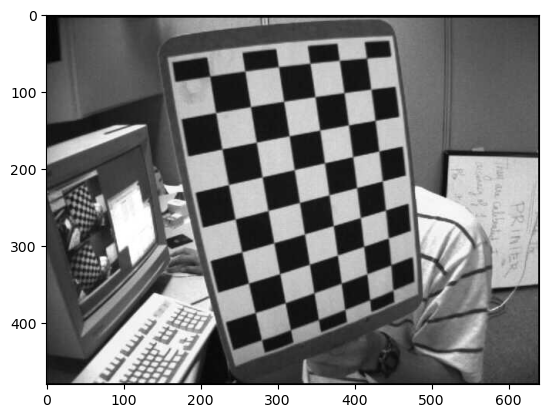

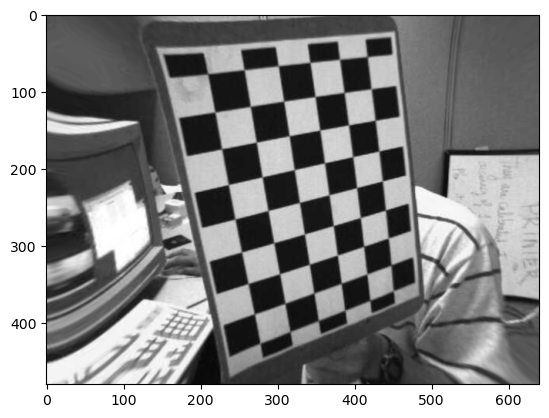

In [17]:
img = cv.imread("Chessboards/left14.jpg")
dst = cv.undistort(img, K, np.array([k[0], k[1], 0, 0, 0]))
plt.imshow(img)
plt.figure(), plt.imshow(dst)
plt.show()

# Part V: comparison with openCV calibration result.

Now, we will use openCV calibration function to compare their results with ours. The above cell enables to do so. Compare your calibration matrix, rotation and translation with the result. Conclusions ?

Remark: to obtain the rotation matrices, you can use cv.Rodrigues(rvecs[k])[0]

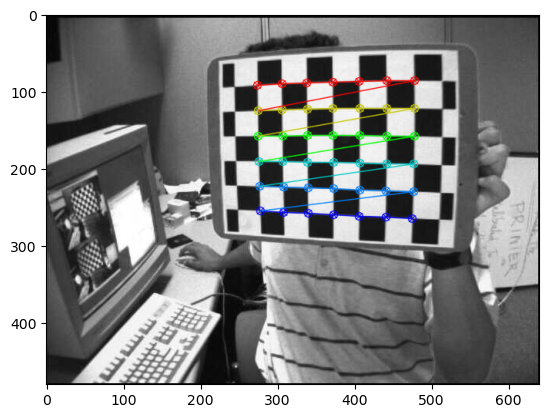

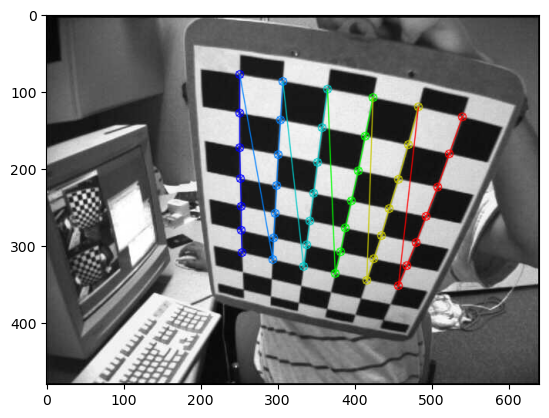

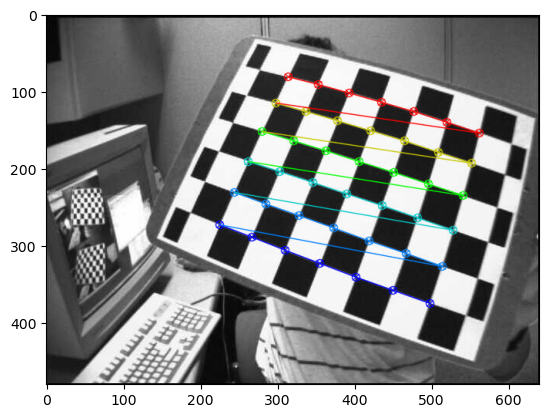

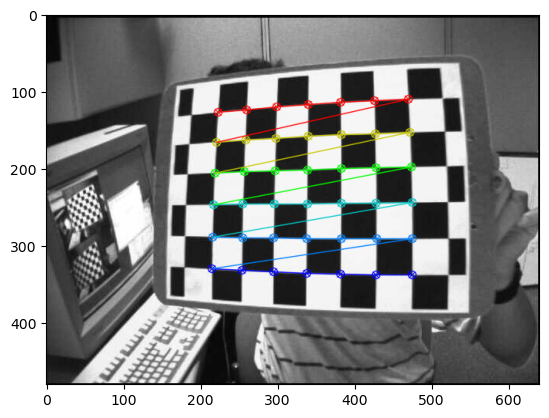

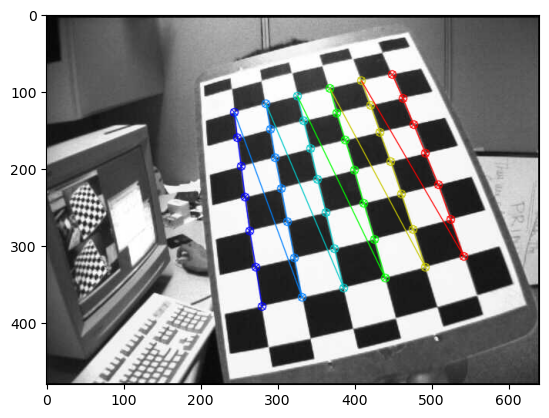

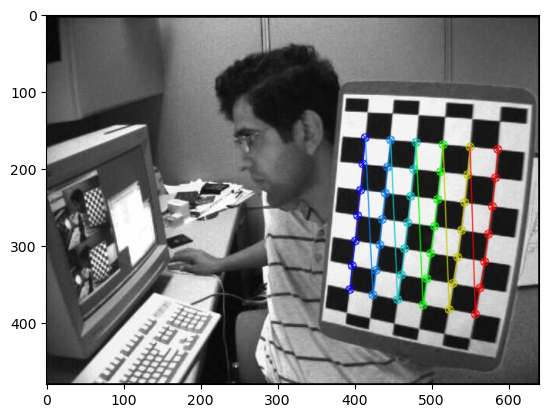

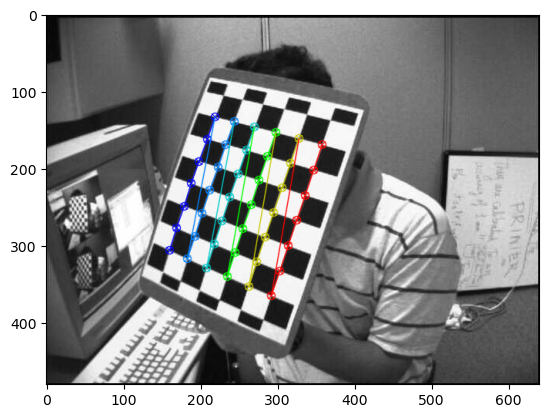

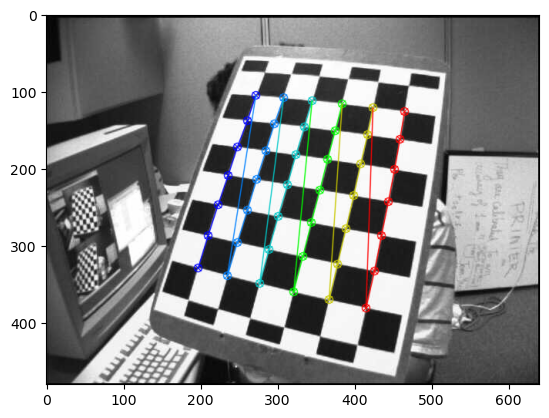

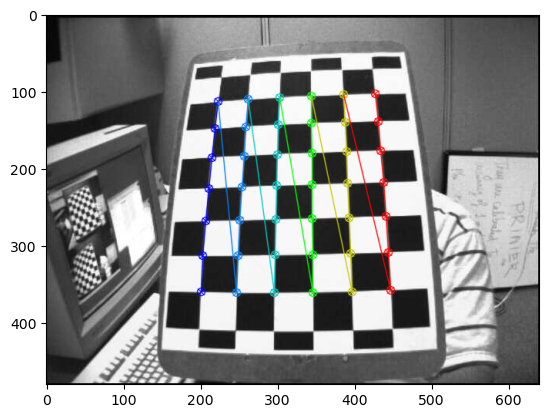

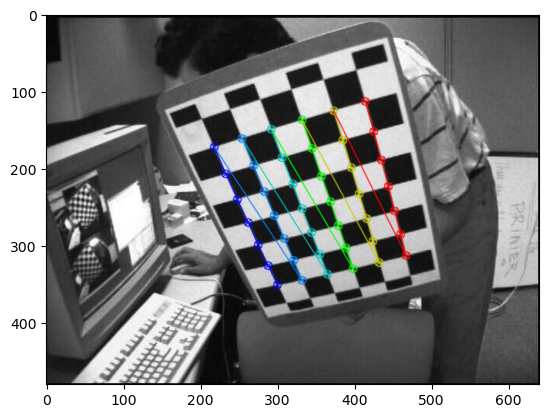

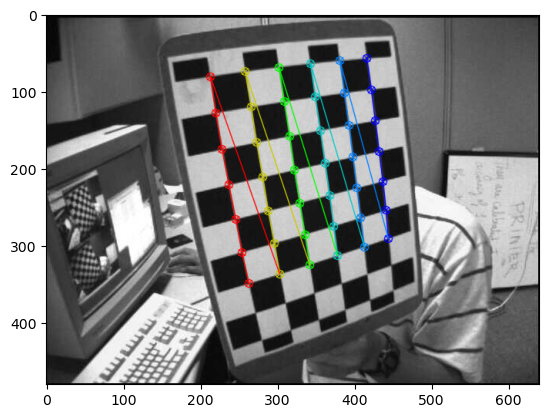

In [18]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6 * 7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:6].T.reshape(-1, 2)
# Arrays to store object points and image points from all the images.
# 3d point in real world space. List (length = nb of images) of np.array, each of size = 3 (corresponding to the 3D Euclidiean coordinates - the last coordinate is always chosen to be 0)
objpoints = []
# 2d points in image plane. List (length = nb of images) of np.array, each of size = 2 (corresponding to the 2D Euclidiean coordinates - the coordinates might not be integers)
imgpoints = []
images = glob.glob("Chessboards/*.jpg")
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7, 6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7, 6), corners2, ret)
        plt.imshow(img)
        plt.show()

**Answer:**

The relatively similar calibration matrices obtained from both calibration methods suggest that they effectively capture identical camera properties. However, minor discrepancies between the matrices may arise due to factors like the quality and selection of calibration images, the accuracy of detected feature points, and the numerical methods employed for parameter computation. Despite these variations, the consistency observed in focal lengths and principal points indicates that both methods yield reliable estimations of the camera's intrinsic parameters. To enhance calibration precision, it is advisable to employ high-quality images, ensure accurate feature point detection, and potentially incorporate averaging of results across multiple calibration runs or utilize more sophisticated optimization routines. By implementing these improvements, more robust and accurate calibration outcomes can be attained.

In [19]:
ret, K, dist, rvecs, tvecs = cv.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

In [20]:
print(cv.Rodrigues(rvecs[2])[0])

[[-0.92086474  0.36672175  0.13237558]
 [-0.31481472 -0.89968619  0.30241768]
 [ 0.22999962  0.23681199  0.94393869]]


In the following cell, the original image and its distorted version using openCV estimation is plotted. Compare with your results. What could explain the differences? You can also use the last cell to compute the projection error.

**Answer:**

The OpenCV distortion estimation effectively identifies and eliminates distortion without noticeable radial distortion increase near the image borders, unlike our implementation. Interestingly, the distortion does not seem to significantly impact corner detection, as evidenced by the low mean error in corner detection even after applying the OpenCV correction. This might be due to the checkerboard pattern identified being close to the image center, where the radial distortion is lower.

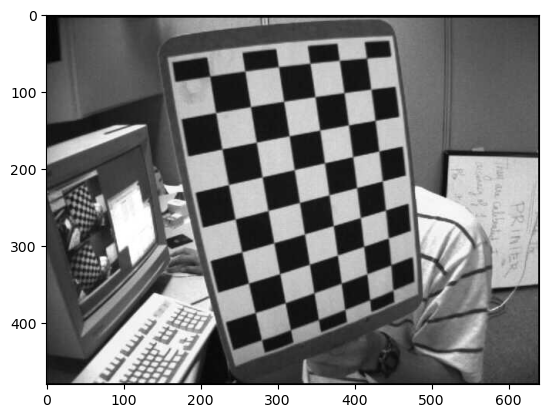

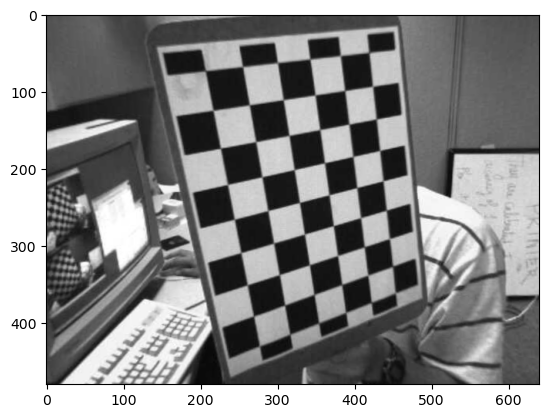

In [21]:
img = cv.imread("Chessboards/left14.jpg")
dst = cv.undistort(img, K, dist, None, K)
plt.imshow(img)
plt.figure(), plt.imshow(dst)
plt.show()

In [22]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
    error = cv.norm(imgpoints[i].reshape(imgpoints2[:, 0].shape), imgpoints2[:, 0], cv.NORM_L2) / len(imgpoints2)
    mean_error += error
print("total error: {}".format(mean_error / len(objpoints)))

total error: 0.023686000375385676
